<a href="https://colab.research.google.com/github/sayandeepmaity/vseven_lumi/blob/main/hybrid_bilstm_transformer_gunshot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class Weights: {np.int64(0): np.float64(5.15035799522673), np.int64(1): np.float64(0.5537593020272004)}
Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8958 - loss: 0.3524 - val_accuracy: 0.9852 - val_loss: 0.0548
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9752 - loss: 0.0976 - val_accuracy: 0.9926 - val_loss: 0.0364
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9754 - loss: 0.1004 - val_accuracy: 0.9926 - val_loss: 0.0372
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9940 - loss: 0.0354 - val_accuracy: 0.9917 - val_loss: 0.0415
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9909 - loss: 0.0288 - val_accuracy: 0.9963 - val_loss: 0.0291
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9916 - loss: 0.0421 - val_accuracy: 0.9963 - val_loss:

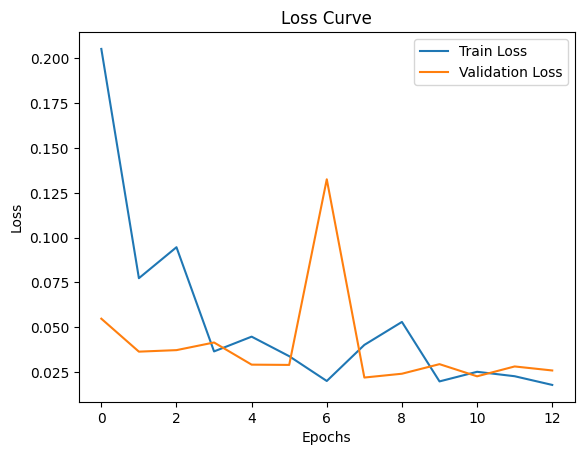

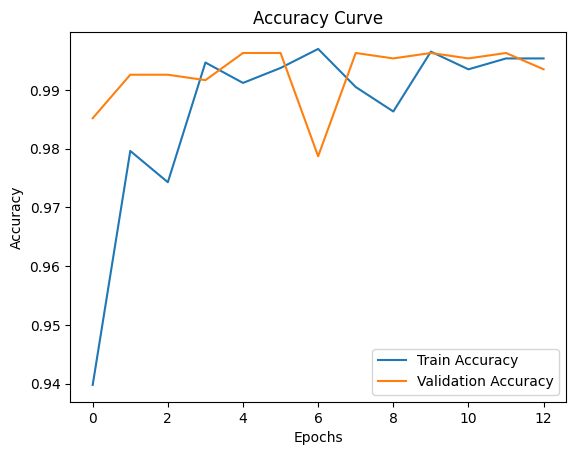

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


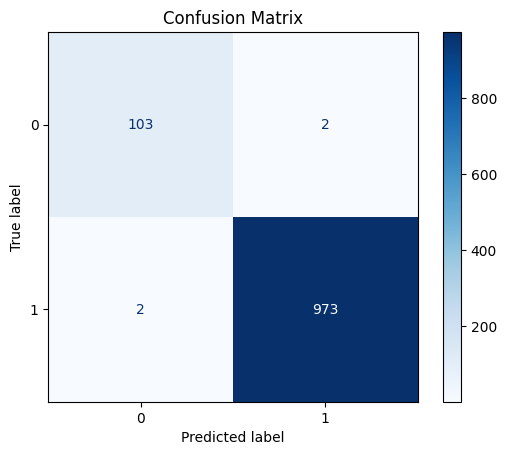

Classification Report:

              precision    recall  f1-score   support

 Non-Gunshot       0.98      0.98      0.98       105
     Gunshot       1.00      1.00      1.00       975

    accuracy                           1.00      1080
   macro avg       0.99      0.99      0.99      1080
weighted avg       1.00      1.00      1.00      1080

Model saved successfully!


In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D, LSTM, Bidirectional
from tensorflow.keras.layers import MultiHeadAttention, Add
from tensorflow.keras.callbacks import EarlyStopping

# Load Data
gunshot_data = pd.read_csv('/content/drive/MyDrive/sevenlumi_data/data_to_fed/cleaned_features.csv')
non_gunshot_data = pd.read_csv('/content/drive/MyDrive/sevenlumi_data/data_to_fed/cleaned_non_gunshot_features.csv')

# Drop unwanted columns
drop_columns = ['Gun_Type', 'Distance', 'X', 'Y', 'Z', 'Mic', 'Arrival_Time_Difference']
gunshot_data = gunshot_data.drop(columns=drop_columns)
non_gunshot_data = non_gunshot_data.drop(columns=drop_columns)

# Combine data
data = pd.concat([gunshot_data, non_gunshot_data], ignore_index=True)

# Features and Labels
X = data.drop(columns=['Gunshot'])
y = data['Gunshot']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Reshape for LSTM input
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", class_weight_dict)

# Build Model
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))

# Bidirectional LSTM Stack
x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.3)(x)

# Multi-Head Attention
attention_out = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
attention_out = Dropout(0.3)(attention_out)
attention_out = LayerNormalization(epsilon=1e-6)(attention_out + x)

# Feed Forward Block (Matching dimension 128)
ffn = Dense(128, activation='relu')(attention_out)
ffn = Dropout(0.3)(ffn)
ffn = Dense(128, activation='relu')(ffn)

# Residual Connection
ffn_output = Add()([attention_out, ffn])
ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)

# Global Pooling
x = GlobalAveragePooling1D()(ffn_output)

# Dense Layers
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)

# Output Layer
output_layer = Dense(1, activation='sigmoid')(x)

# Define Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predictions
y_pred_prob = model.predict(X_test_reshaped)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Non-Gunshot', 'Gunshot']))

# Save Model
model.save('/content/drive/MyDrive/sevenlumi_data/models/hybrid_bilstm_transformer_gunshot_detector_model.h5')
print("Model saved successfully!")
